In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [103]:
etfs = ['XLF','XLK','XLE','XLV','XLI','XBI','XLU','XLP','XLY','KRE','XLB','XLC','XRT','XOP','XLRE','XHB','KBE','XME','KIE','XSD','XAR','XES','KCE','XNTK','XHE','XSW','XPH','XTN','XHS','XITK','XTL']
prices = yf.download(tickers=etfs, period='max')['Close'].dropna()
prices

[*********************100%***********************]  31 of 31 completed


Ticker,KBE,KCE,KIE,KRE,XAR,XBI,XES,XHB,XHE,XHS,...,XLY,XME,XNTK,XOP,XPH,XRT,XSD,XSW,XTL,XTN
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,40.928894,52.372849,26.954386,52.737858,82.541725,98.345161,151.031921,37.949108,80.422546,68.701027,...,104.431427,33.191647,71.674652,142.970627,41.207874,44.751892,73.978622,83.494713,69.030251,61.895100
2018-06-20,41.027897,52.545094,26.761166,52.836594,83.034790,100.633423,151.580826,38.024204,80.462440,69.402565,...,104.926567,33.565907,72.171661,145.407806,41.568859,45.207893,74.619308,83.780533,69.048943,62.491936
2018-06-21,40.895901,51.976673,26.515247,52.729630,82.418472,98.554085,147.647217,37.639282,79.604866,69.335266,...,104.179153,33.136871,71.541115,141.631882,40.856144,45.252602,73.561211,82.637299,67.983200,62.202835
2018-06-22,40.499889,52.019733,26.611856,52.211300,82.617561,98.573997,153.501846,37.413940,80.073540,69.431366,...,104.001633,33.775871,71.125702,146.197296,40.680267,45.100597,73.134087,81.760185,67.702736,61.829815
2018-06-25,40.087391,51.141247,26.506462,51.717651,81.565071,95.907684,148.927917,36.953896,78.567802,68.835579,...,101.740746,32.452225,69.115349,142.352753,40.069370,44.394218,71.037354,79.798973,66.749191,60.076569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,54.869999,141.210007,59.490002,58.419998,200.889999,83.820000,64.040001,98.370003,80.949997,97.709999,...,215.589996,65.940002,233.539993,128.039993,41.500000,77.220001,253.809998,185.619995,114.699997,80.059998
2025-06-25,54.630001,141.860001,58.139999,58.139999,201.610001,83.269997,62.880001,96.839996,80.610001,96.989998,...,213.050003,65.529999,233.550003,126.139999,41.070000,76.470001,254.360001,183.460007,114.699997,79.099998
2025-06-26,55.779999,143.360001,58.980000,59.480000,206.970001,83.680000,64.120003,97.599998,80.639999,98.290001,...,215.009995,67.300003,235.490005,127.779999,41.040001,76.629997,257.779999,187.039993,116.059998,80.019997


In [108]:
# Constants for the model
up_period = 20
down_period = 40
keltner_mult = 2
atr_approx_factor = 1.4
vol_window = 14
max_leverage = 1 # TODO: How does leverage work?
target_vol = 0.015  # 1.5%

# Sample structure of a strategy function
def trend_following_strategy(prices: pd.DataFrame):
    returns = prices.pct_change()
    volatility = returns.rolling(vol_window).std()
    weights = pd.DataFrame(index=prices.index, columns=prices.columns, data=0.0).to_dict()
    positions = pd.DataFrame(index=prices.index, columns=prices.columns, data=False).to_dict()

    channels = dict()
    keltner_channels = dict()
    donchian_channels = dict()
    for j in prices.columns:
        for pos in ['up', 'price', 'down']:
            channels[(j, pos)] = dict()
            keltner_channels[(j, pos)] = dict()
            donchian_channels[(j, pos)] = dict()


    ema_up = prices.ewm(span=up_period, adjust=False).mean()
    ema_down = prices.ewm(span=down_period, adjust=False).mean()
    atr_approx_up = atr_approx_factor * returns.abs().rolling(up_period).mean()
    atr_approx_down = atr_approx_factor * returns.abs().rolling(down_period).mean()

    keltner_up = ema_up + keltner_mult * atr_approx_up
    keltner_down = ema_down + keltner_mult * atr_approx_down
    donchian_up = prices.rolling(up_period).max()
    donchian_down = prices.rolling(down_period).min()

    upper_band = np.minimum(donchian_up, keltner_up)
    lower_band = np.maximum(donchian_down, keltner_down)

    long_trailing_stop = [lower_band.iloc[0]]
    for t in range(1, len(lower_band.index)):
        long_trailing_stop_t = np.maximum(long_trailing_stop[t - 1], lower_band.iloc[t])
        long_trailing_stop.append(long_trailing_stop_t)
    long_trailing_stop = pd.DataFrame(index=lower_band.index, columns=lower_band.columns, data=long_trailing_stop)

    for j in prices.columns:
        channels[(j, 'down')] = lower_band[j]
        channels[(j, 'price')] = prices[j]
        channels[(j, 'up')] = upper_band[j]
        keltner_channels[(j, 'down')] = keltner_down[j]
        keltner_channels[(j, 'price')] = prices[j]
        keltner_channels[(j, 'up')] = keltner_up[j]
        donchian_channels[(j, 'down')] = donchian_down[j]
        donchian_channels[(j, 'price')] = prices[j]
        donchian_channels[(j, 'up')] = donchian_up[j]

    for t in range(max(up_period, down_period, vol_window), len(prices)):
        date = prices.index[t]
        prev_date = prices.index[t - 1]
        for j in prices.columns:
            prev_position = positions[j][prev_date]
            prev_price = prices[j].iloc[t - 1]

            # Entry condition
            if not prev_position and prev_price >= upper_band[j].iloc[t - 1]:
                positions[j][date] = True
            # Exit condition
            elif prev_position:
                if prev_price < long_trailing_stop[j].iloc[t - 1]:
                    positions[j][date] = False
                else:
                    positions[j][date] = True
            else:
                positions[j][date] = False

        active = dict()
        for j in prices.columns:
            active[j] = positions[j][date]
        n_active = sum(active.values())
        weights_today = {}
        for j in prices.columns:
            if active[j]:
                sigma = volatility[j].iloc[t]
                if pd.notna(sigma) and sigma > 0:
                    w = (target_vol / n_active) / sigma
                    weights_today[j] = w
                else:
                    weights_today[j] = 0
            else:
                weights_today[j] = 0
        exposure = sum(weights_today.values())
        if exposure > max_leverage:
            scaling_factor = max_leverage / exposure
            for j in weights_today:
                weights_today[j] *= scaling_factor
        for j in prices.columns:
            weights[j][date] = weights_today.get(j, 0.0)

    weights = pd.DataFrame(data=weights, index=prices.index, columns=prices.columns)
    positions = pd.DataFrame(data=positions, index=prices.index, columns=prices.columns)
    strategy_returns = (weights * returns).sum(axis=1)
    channels = pd.DataFrame.from_dict(channels)
    keltner_channels = pd.DataFrame.from_dict(keltner_channels)
    donchian_channels = pd.DataFrame.from_dict(donchian_channels)
    return strategy_returns, weights, positions, long_trailing_stop, channels, keltner_channels, donchian_channels

In [109]:
strategy_returns, weights, positions, long_trailing_stop, channels, keltner_channels, donchian_channels = trend_following_strategy(prices['2024-03-01':])

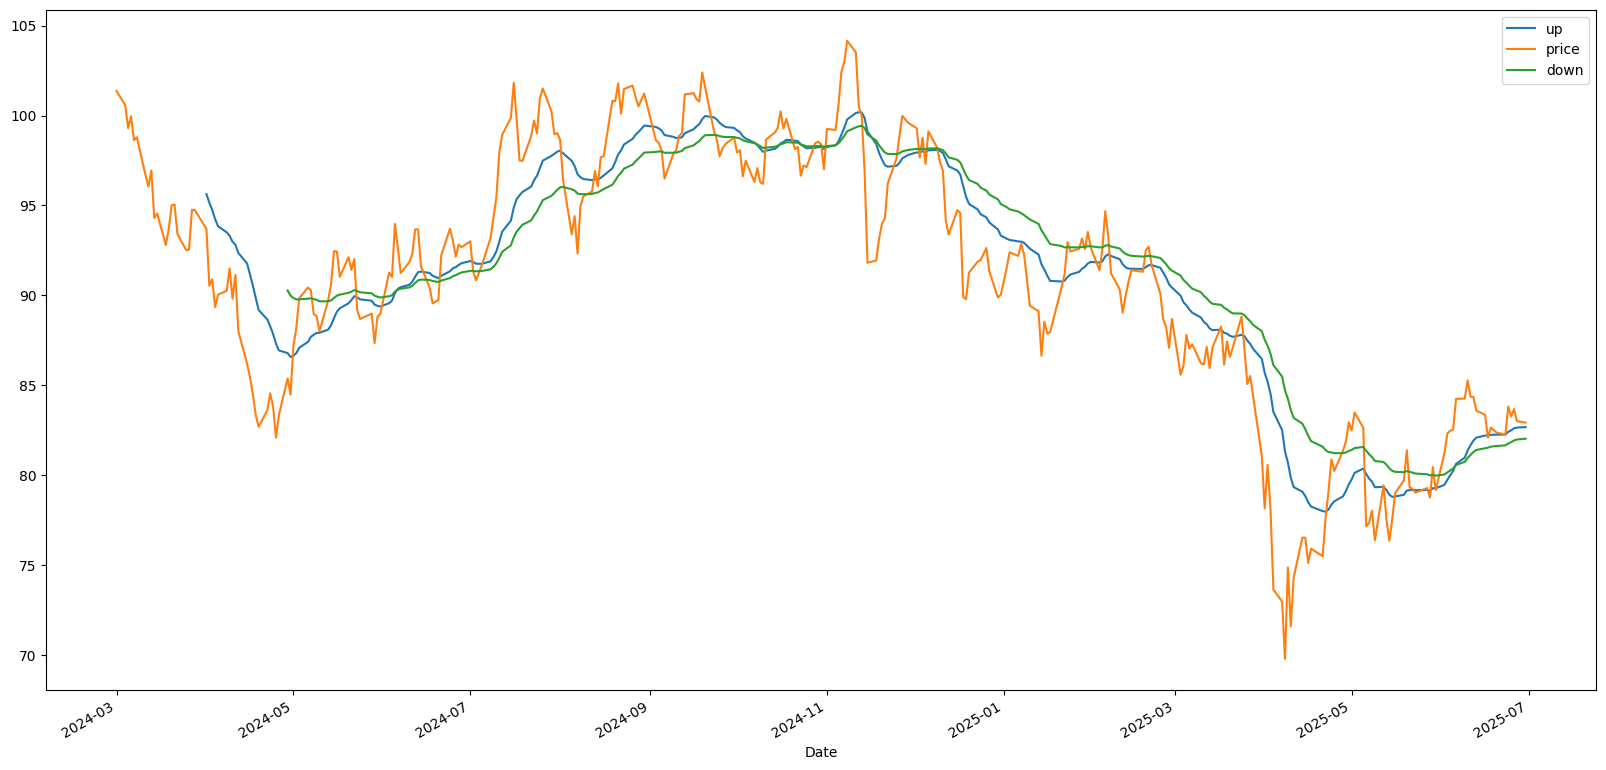

In [110]:
channels['XBI'].plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))

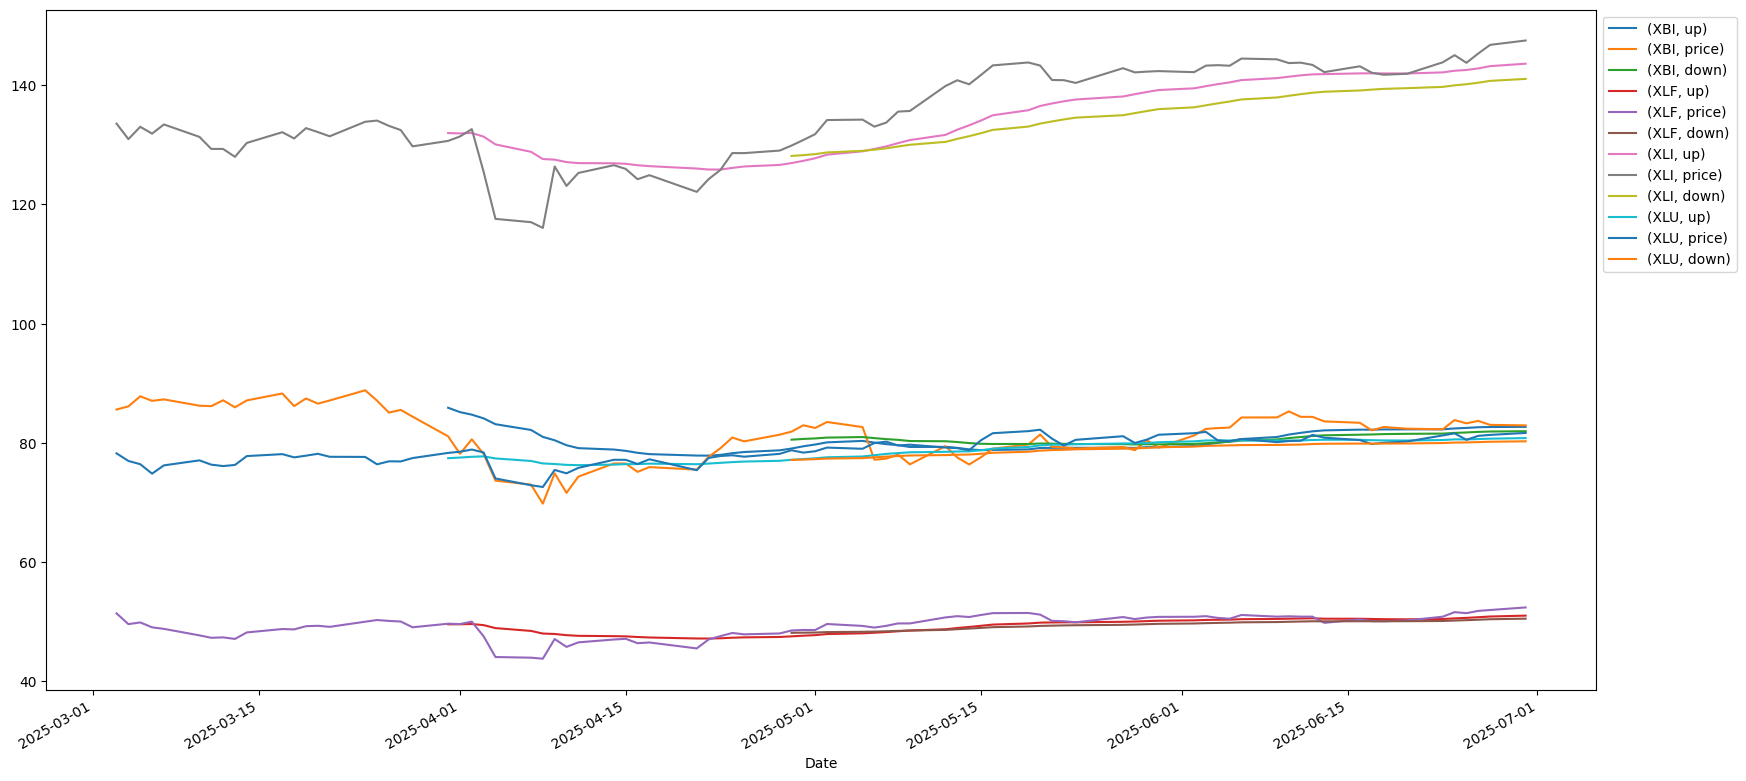

In [72]:
keltner_channels.plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))

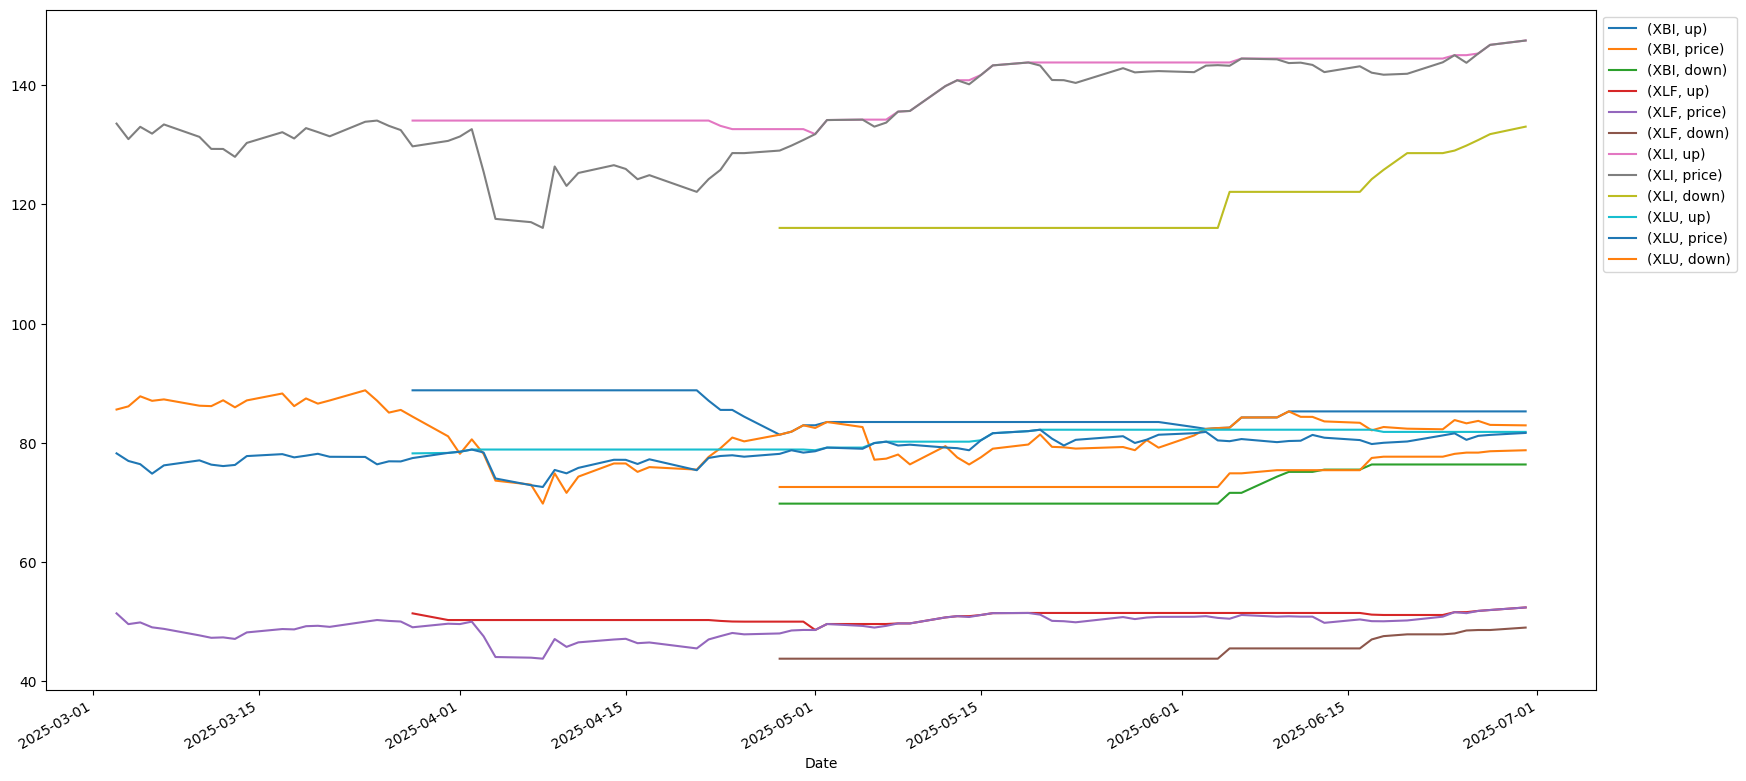

In [73]:
donchian_channels.plot(figsize=(20, 10)).legend(bbox_to_anchor=(1.0, 1.0))